In [1]:
import torch
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, inc, outc, k, s, p, bn=True, subpix=False):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(inc, outc, kernel_size=k, stride=s, padding=p),
            nn.BatchNorm1d(outc) if bn else nn.Identity(),
            nn.LeakyReLU(0.2)
        )
        self.subpix = subpix
        if subpix:
            self.ps = nn.PixelShuffle(2)

    def forward(self, x):
        if self.subpix:
            x = self.ps(x.unsqueeze(2))
            b, c, h, w = x.shape
            x = x.reshape(b, c * h, w)
        out = self.block(x)
        return out
        
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(129, 256, 7, 2, 3), # 16x256
            ConvBlock(256, 512, 5, 2, 2), # 8x512
            ConvBlock(512, 512, 3, 2, 1)  # 4x512
        )
        
        self.bottle = ConvBlock(512, 1024, 3, 2, 1) # 2x1024
        
        self.decoder = nn.Sequential(
            ConvBlock(512, 512, 3, 1, 1, subpix=True), # +4x512 skip
            ConvBlock(512, 512, 5, 1, 2, subpix=True), # +8x512 skip
            ConvBlock(512, 256, 7, 1, 3, subpix=True) # +16x256 skip
        )
        
        self.final = nn.Sequential(
            ConvBlock(256, 141, 7, 1, 3, subpix=True),
            ConvBlock(141, 141, 9, 1, 4, bn=False) # тут лрелу в конце!
        )

    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)
        x = self.bottle(x)
        
        for layer in self.decoder:
            x = layer(x)
            x = torch.cat([x, skips.pop()], dim=1)

        out = self.final(x)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            ConvBlock(129 + 141, 1024, 7, 2, 3, bn=False),
            ConvBlock(1024, 1024, 5, 2, 2, bn=False),
            ConvBlock(1024, 1024, 3, 2, 1, bn=False),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * 1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1),
        )
   
    def forward(self, x):
        x = self.convs(x)
        out = self.fc(x)
        return out, torch.sigmoid(out)

In [2]:
def reconstruction_loss(true, pred):
    return torch.mean(torch.sqrt(torch.mean(
                torch.square(torch.sub(true, pred)), dim=1)))

def regularization_term(fake_prob, real_prob, fake_logit, real_logit):
    real_grad = torch.autograd.grad(outputs=real_prob, inputs=real_logit,
                                grad_outputs=torch.ones_like(real_prob),
                                retain_graph=True, create_graph=True, only_inputs=True)[0]
    fake_grad = torch.autograd.grad(outputs=fake_prob, inputs=fake_logit,
                                grad_outputs=torch.ones_like(fake_prob),
                                retain_graph=True, create_graph=True, only_inputs=True)[0]
    
    ep = torch.mean(torch.square(1 - real_prob) * torch.square(torch.norm(real_grad)))
    eq = torch.mean(torch.square(fake_prob) * torch.square(torch.norm(fake_grad)))
    return ep + eq

def disc_loss(fake_prob, real_prob):
    return torch.mean(torch.log(real_prob)) + torch.mean(torch.log(1 - fake_prob))

def gen_loss(fake_prob):
    return torch.mean(-torch.log(fake_prob))

def segsnr(true, pred):
    return torch.mean(10 * torch.log(torch.div(
                torch.mean(torch.square(true), 2), 
                torch.mean(torch.square(true - pred), 2))), 1)

In [3]:
G = Generator()
D = Discriminator()
optimizerG = torch.optim.Adam(G.parameters(), lr=1e-4)  # 1e-5 after 50 epoch
optimizerD = torch.optim.RMSprop(D.parameters(), lr=1e-4)  # 1e-5 after 50 epoch
gamma = 1
lambd = 0.5
batch = 64

In [4]:
real_lf = torch.rand(1, 129, 32)
real_hf = torch.rand(1, 141, 32)
fake_hf = G(real_lf)
fake_full = torch.cat([real_lf, fake_hf], dim=1)
real_full = torch.cat([real_lf, real_hf], dim=1)
fake_logit, fake_prob = D(fake_full)
real_logit, real_prob = D(real_full)

# segsnr(real_full, fake_full)

In [5]:
lossD = disc_loss(fake_prob, real_prob) + 0.5 * gamma * regularization_term(fake_prob, real_prob, fake_logit, real_logit)
lossG = gen_loss(fake_prob) + lambd * reconstruction_loss(real_full, fake_full)
lossD.backward(retain_graph=True)
lossG.backward()

In [6]:
lossD.item(), lossG.item()

(-1.3684453964233398, 0.896089494228363)

In [7]:
# !pip3 install pesq

In [28]:
from scipy.io import wavfile
from pesq import pesq

rate, ref = wavfile.read("5_gt.wav")
rate, deg = wavfile.read("5_gen.wav")
print(rate)
print(pesq(rate, ref, deg, 'wb'))

16000
1.6282330751419067


In [9]:
# 32 ms window size, 8 ms hop size
# the log and power operations to obtain LPS
# chopped up the utterances into T=32 timesteps
spec_kwargs = dict(n_fft=(141 + 129) * 2 - 1, win_length=32, hop_length=8)

import torchaudio
import matplotlib.pyplot as plt

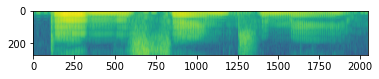

In [29]:
make_spectrogram = torchaudio.transforms.Spectrogram(**spec_kwargs)
plt.imshow(make_spectrogram(torch.tensor(ref.copy())).log())

In [48]:
stft = torch.stft(torch.tensor(ref.copy()), **spec_kwargs)
torchaudio.functional.complex_norm(stft)
torchaudio.functional.angle(stft) == phase

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [47]:
phase

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-3.1265,  3.1096,  3.1099,  ..., -3.1163, -3.1345,  3.1374],
        [ 0.0303, -0.0648, -0.0638,  ...,  0.0508,  0.0142, -0.0088],
        ...,
        [-3.1023,  2.5982,  2.0582,  ..., -2.9506,  2.9705,  2.7156],
        [ 0.0982, -0.7974, -1.2746,  ...,  0.3508, -0.2578, -0.6424],
        [-2.8092,  1.8830,  1.6702,  ..., -2.2810,  2.4953,  1.9919]])

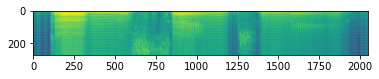

In [41]:
mag, phase = torchaudio.functional.magphase()
plt.imshow(mag.log())
plt.imshow(phase.log())

In [25]:
real_image = torch.stft(torch.tensor(ref.copy()), **spec_kwargs)

In [ ]:
import torch
from torch.nn.utils import clip_grad_norm_
from external_modules import torch_audio
from utils import complex_torch


class Runner:
    def __init__(self, model, metric, optimizer, max_grad_norm, p, stft_kwargs):
        self.model = model
        self.metric = metric
        self.optimizer = optimizer
        self.max_grad_norm = max_grad_norm
        self.stft_kwargs = stft_kwargs
        self.p = p

    def compress(self, x):
        mag = torch_audio.complex_norm(x, self.p)
        phase = complex_torch.phase(torch_audio.angle(x))
        result = complex_torch.product(
            complex_torch.from_real_and_imag(
                mag, torch.zeros_like(mag)
            ),
            phase
        )
        return result

    def decompress(self, x):
        mag = torch_audio.complex_norm(x, 1. / self.p)
        phase = complex_torch.phase(torch_audio.angle(x))
        result = complex_torch.product(
            complex_torch.from_real_and_imag(
                mag, torch.zeros_like(mag)
            ),
            phase
        )
        return result

    def step(self, *args, train=True):
        to_return = {}
        x, y = args
        x_stft_no_norm = torch.stft(x, **self.stft_kwargs)
        y_stft_no_norm = torch.stft(y, **self.stft_kwargs)
        x_stft = self.compress(x_stft_no_norm)
        y_stft = self.compress(y_stft_no_norm)
        mask = self.model(x_stft)
        assert mask.shape == x_stft.shape
        stft_pred = complex_torch.product(x_stft, mask)

        stft_pred_flat = stft_pred.reshape(stft_pred.shape[0], -1)
        stft_true_flat = y_stft.reshape(y_stft.shape[0], -1)
        loss = torch.nn.functional.mse_loss(
            stft_pred_flat, stft_true_flat, reduction='none'
        ).mean(-1)

        assert loss.dim() >= 1
        loss = loss.view(loss.shape[0], -1).mean(-1)
        to_return['loss'] = loss.detach().cpu().numpy()

        model_out = torch_audio.istft(
            self.decompress(stft_pred),
            **self.stft_kwargs
        )
        true_out = torch_audio.istft(y_stft_no_norm, **self.stft_kwargs)
        metric = self.metric(model_out, true_out)
        assert metric.dim() >= 1
        to_return['metric'] = metric.detach().cpu().numpy()
        if train:
            self.optimizer.zero_grad()
            loss.mean().backward()
            grad_norm = clip_grad_norm_(
                self.model.parameters(), self.max_grad_norm)
            to_return['grad_norm'] = grad_norm
            self.optimizer.step()
        return to_return
